In [ ]:
# original data can be downloaded from: https://github.com/kapelner/predicting_contextual_informativeness

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import nltk
import spacy
import re

In [2]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [3]:
from tqdm import tqdm_notebook

# -1. Filtering Kapelner et al. sentences 
- sentences with inappropriate score counts
- rows with missing features

In [ ]:
## filtering the original data
# df_contexts = pd.read_pickle('dataset/predicting_contextual_informativeness-master/kapelner_context.pickle')
# df_contexts = df_contexts[df_contexts['mean_rating']!=0] # sentences with inappropriate score counts
# df_contexts = df_contexts.dropna()                       # rows with missing features
# df_contexts = df_contexts.reset_index(drop=True)
# df_contexts.to_pickle('dataset/predicting_contextual_informativeness-master/kapelner_context_filtered.pickle')

In [4]:
df_contexts = pd.read_pickle('dataset/predicting_contextual_informativeness-master/kapelner_context_filtered.pickle')

# 0. sentence segmentation and target word matching 

In [5]:
nlp = spacy.load("en")

In [6]:
def sent_tokenizer_targ(spacy_nlp, contexts, targets):
    sent_tok_out = []
    
    # separate special characters with word (to help tokenization process)
    # contexts = [sents.replace(targ, ' '+targ+' ') for sents, targ in zip(contexts, targets)]
    
    # find the target word
    for doc, targ in tqdm_notebook(zip(nlp.pipe(contexts), targets)):
        sents = {'sents':[], 'sent_tok':[], 'target_insent':None, 'target_stated':targ}
        # 1. match the lemma from spacy
        temp_targ_insent = []
        for sent in doc.sents:
            # save sentence list
            sents['sents'].append(sent.text)
            temp_sent_tok = []
            
            # save tokenized sentence
            for tok in sent:
                temp_sent_tok.append(tok.text)

                # if lemma of the sentence's token matches the specified target word
                if tok.lemma_==targ:
                    temp_targ_insent.append(tok.text)
            sents['sent_tok'].append(temp_sent_tok)
            
        # selects the first in-sentence target word appearance
        if(temp_targ_insent):             
            sents['target_insent'] = temp_targ_insent[0]            
        
        # 2. reiterate if the target word was not found in sentences; choose the token with the smallest edit distance
        if(sents['target_insent']==None):
            targ_insent_scr = float('inf')
            for sent in doc.sents:
                dist_tok_targ = np.array([nltk.edit_distance(tok.text, targ) for tok in sent])
                temp_insent_scr = dist_tok_targ[dist_tok_targ.argmin()]
                if(temp_insent_scr < targ_insent_scr):
                    sents['target_insent'] = sent[dist_tok_targ.argmin()].text
                    targ_insent_scr = temp_insent_scr            
        sent_tok_out.append(sents)
    return(np.array(sent_tok_out))

In [7]:
# contexts = sent_tokenizer_targ(nlp, df_contexts['context'].values, df_contexts['target_word'].values)

In [8]:
# np.save("dataset/predicting_contextual_informativeness-master/kapelner_context_sentence_targ_match_tok.npy", contexts, allow_pickle=True)

In [9]:
# def separate_special_char(contexts):
# #     contexts = [re.sub(r'([!"#$%&()*+,-./\:;\<=?@\[\\\]^_`{|}~\t\n\'])',r' \1 ', sents).replace(' .  .  . ', '') \
# #                 for sents in contexts]
#     contexts = [re.sub(r'([^\w])', r'\1', sents) for sents in contexts]
#     return(contexts)

# df_contexts['context'] = separate_special_char(df_contexts['context'])

# def sentence_indexer(spacy_nlp, contexts, targets):
#     sentences_out = []
    
#     # separate special characters with word (to help tokenization process)
#     # contexts = [sents.replace(targ, ' '+targ+' ') for sents, targ in zip(contexts, targets)]
    
#     # find the target word
#     for doc, targ in tqdm_notebook(zip(nlp.pipe(contexts), targets)):
#         sents = {'sents':[], 'target_insent':None, 'target_stated':targ}
#         # 1. match the lemma from spacy
#         for i, sent in enumerate(doc.sents):            
#             sents['sents'].append(sent.text)

#             temp_targ_insent = [tok.text for tok in sent if tok.lemma_==targ]
#             if(temp_targ_insent): 
#                 sents['target_insent'] = temp_targ_insent[0]
        
#         # 2. reiterate if the target word was not found in sentences; choose the token with the smallest edit distance
#         if(sents['target_insent']==None):
#             targ_insent_scr = float('inf')
#             for sent in doc.sents:
#                 dist_tok_targ = np.array([nltk.edit_distance(tok.text, targ) for tok in sent])
#                 temp_insent_scr = dist_tok_targ[dist_tok_targ.argmin()]
#                 if(temp_insent_scr < targ_insent_scr):
#                     sents['target_insent'] = sent[dist_tok_targ.argmin()].text
#                     targ_insent_scr = temp_insent_scr            
#         sentences_out.append(sents)
#     return(np.array(sentences_out))

# contexts = sentence_indexer(nlp, df_contexts['context'].values, df_contexts['target_word'].values)

# contexts[526]

# [cntx for cntx in contexts if cntx['target_insent']!=cntx['target_stated']][:3]

# np.save("dataset/predicting_contextual_informativeness-master/kapelner_context_sentence_targ_match.npy", contexts, allow_pickle=True)

## save with the original dataframe

In [10]:
contexts = np.load("dataset/predicting_contextual_informativeness-master/kapelner_context_sentence_targ_match_tok.npy", allow_pickle=True)

In [11]:
df_contexts['context_sents'] = [cntx['sents'] for cntx in contexts]
df_contexts['context_sents_tok'] = [cntx['sent_tok'] for cntx in contexts]
df_contexts['target_word_insent'] = [cntx['target_insent'] for cntx in contexts]

In [12]:
df_contexts.to_pickle('dataset/predicting_contextual_informativeness-master/kapelner_context_filtered2_targ_match.pickle.gz', compression='gzip')

In [13]:
df_contexts['context_sents'][:4]

0    [The book Manipur:, A Tourist Paradise is a un...
1    [Although as Billy Bragg, who knows a thing or...
2    [Self honor is how self views himself or herse...
3    [As with ginger, turmeric has salubrious prope...
Name: context_sents, dtype: object

In [14]:
df_contexts['context_sents_tok'][:4]

0    [[The, book, Manipur, :], [A, Tourist, Paradis...
1    [[Although, as, Billy, Bragg, ,, who, knows, a...
2    [[Self, honor, is, how, self, views, himself, ...
3    [[As, with, ginger, ,, turmeric, has, salubrio...
Name: context_sents_tok, dtype: object

In [15]:
df_contexts['context_sents'][:4].apply(lambda x:len(x)) # separating : as a sentence

0    4
1    1
2    3
3    3
Name: context_sents, dtype: int64

In [16]:
df_contexts['num_sentences'][:4]

0    3
1    1
2    3
3    3
Name: num_sentences, dtype: int64

In [17]:
df_contexts = pd.read_pickle('dataset/predicting_contextual_informativeness-master/kapelner_context_filtered2_targ_match.pickle.gz', compression='gzip')

In [18]:
df_contexts.shape

(67831, 627)

# 1. For ELMo models 

In [19]:
mm_scaler = MinMaxScaler()
# info_scores = mm_scaler.fit_transform(df_contexts[['mean_rating']])
# info_scores = info_scores[:,0]
df_contexts['mm_mean_rating'] = mm_scaler.fit_transform(df_contexts[['mean_rating']])[:,0]

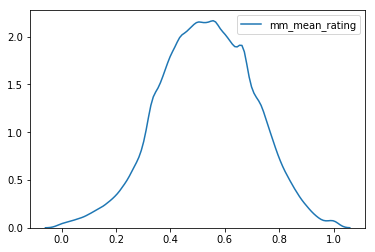

In [20]:
sns.kdeplot(df_contexts['mm_mean_rating'])

In [21]:
from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
import math

Using TensorFlow backend.


In [22]:
col_features_top30 = ['similar_1_10', 'collocation_1_10', 'count:target-word1', 'politeness_component', 
                'Kuperman AoA AW', 'Kuperman AoA CW', 'count:word1-target-word2', 'MRC Meaningfulness CW', 
                'num_times_target_exact_match', 'num_acronyms', 'repeated_content_lemmas_pronoun', 'Polit_GI', 
                'prob:word1-target-word2', 'prob:target-word1', 'All AWL Normed',  'MRC Meaningfulness AW', 
                'affect_friends_and_family_component', 'Positive_EmoLex', 'count:target', 'num_times_target_stem_match', 
                'SUBTLEXus Freq AW', 'Econ_GI', 'prob:word1-word2-target', 'BNC Written Bigram Proportion',
                'Arousal_nwords', 'SUBTLEXus Range CW Log', 'BNC Written Trigram Proportion', 'disjunctions',
                'Arousal', 'Brown Freq CW Log']

In [23]:
col_features_all = df_contexts.columns.tolist()[6:-5]

# # taking off:  'num_times_target_exact_match', 'num_times_target_stem_match'
# col_features_all.remove('num_times_target_exact_match')
# col_features_all.remove('num_times_target_stem_match')

len(col_features_all)

617

In [24]:
df_contexts['context_sents_tok'].apply(lambda x:len([tok for sent in x for tok in sent])).max()

160

In [25]:
MAX_SEQ_LEN = 160
CUT_SEQ_LEN = 30
# FILTERS = '“”"#$%&()*+/=@[\\]^_`{|}~\t\n:' #'!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'
_err_sent_idx = []

def proc_sentences(df, col_sent_tok, col_targ, col_features, col_score, 
                   cut_sentence=True, incld_targ=False, max_seq_len=MAX_SEQ_LEN):
    sentences = []
    li_mask_cntx = []
    li_mask_targ = []
    li_sent_len = []
    li_sent_pad = []
    li_targ = []
    li_feat = []
    li_score = []
    for i in tqdm_notebook(range(df.shape[0])):
        sent_tok = [tok for sent in df.iloc[i][col_sent_tok] for tok in sent] # tokenized sentences as a single list        
        score = df.iloc[i][col_score]
        feat = df.iloc[i][col_features].values
        targ = df.iloc[i][col_targ]
        score = df.iloc[i][col_score]
        
        sent_pad = None
#         try:         
        prepad_targ_idx = np.where((targ==np.array(sent_tok)))[0][0]
#             if(len(temp_targ_idx)):
#                 temp_targ_idx = temp_targ_idx[0]
#             else:
#                 temp_targ_idx = np.where(pd.Series(sent_tok).str.contains(targ))[0][0]
        if(cut_sentence):
            sent_pad = None
            len_lh = len(sent_tok[:prepad_targ_idx])
            len_rh = len(sent_tok[prepad_targ_idx:])
            if((len_lh + len_rh) < max_seq_len):
                # if the sentence length is shorter
                sent_pad = pad_sequences([sent_tok], maxlen=max_seq_len, dtype='object', padding='post', value=[""])
            else:

                len_lh = math.floor((len_lh/len(sent_tok))*max_seq_len)
                len_rh = math.ceil((len_rh/len(sent_tok))*max_seq_len)

                sent_tok = sent_tok[(prepad_targ_idx-len_lh):(prepad_targ_idx+len_rh)]
                sent_pad = pad_sequences([sent_tok], maxlen=max_seq_len, dtype='object', padding='post', value=[""])
        else:
            sent_pad = pad_sequences([sent_tok], maxlen=max_seq_len, dtype='object', padding='post', value=[""])

        pad_targ_idx = np.where(targ==sent_pad[0])[0][0]

        if(not incld_targ):
            sent_pad[0][pad_targ_idx] = "<UNK>"

        mask_targ = [0]*(max_seq_len)
        mask_targ[pad_targ_idx] = 1
        mask_cntx = [0]*(max_seq_len)

        for i in range(pad_targ_idx):
            mask_cntx[i] = 1
        if(incld_targ):
            for i in range(pad_targ_idx, len(sent_tok)):
                mask_cntx[i] = 1
        else:
            for i in range(pad_targ_idx+1, len(sent_tok)):
                mask_cntx[i] = 1

        sent_len = len(sent_tok)

        li_sent_len.append(sent_len)
        li_sent_pad.append(list(sent_pad)[0])
        li_mask_cntx.append(mask_cntx)
        li_mask_targ.append(mask_targ)
        li_feat.append(feat)

        li_targ.append(targ)
        li_score.append(score)
#         except:
#             _err_sent_idx.append(i)
#             print(sent_tok)
#             print(targ)

    sentences = [np.array(li_sent_len), np.array(li_sent_pad), np.array(li_mask_cntx), np.array(li_mask_targ), np.array(li_feat)]
    return(sentences, li_score, li_targ)

## cut context: 30 words

In [26]:
sentences_notarg, sentences_score, targets = proc_sentences(df_contexts, 'context_sents_tok', 'target_word_insent', col_features_top30, "mm_mean_rating",
                                                            cut_sentence=True, incld_targ=False, max_seq_len=CUT_SEQ_LEN)

In [27]:
sentences_notarg

[array([30, 30, 30, ..., 30, 30, 30]),
 array([['potential', 'for', 'the', ..., 'properly', 'conceived', 'and'],
        ['the', 'height', 'of', ..., 'and', 'politics', ','],
        ['salutary', 'or', 'horrible', ..., 'typically', 'start', 'from'],
        ...,
        ['the', 'film', 'lies', ..., 'review', 'added', 'that'],
        ['executions', ',', 'murder', ..., 'mascot', '-', 'an'],
        ['solve', 'this', 'problem', ..., 'Software', 'and', 'created']],
       dtype=object),
 array([[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1]]),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]),
 array([[0.0, 0.0, 3268, ..., 0.0, 5.03, 1.02144027526],
        [0.0, 0.0, 57, ..., 

In [28]:
np.savez("kapelner_sentences_notarg_elmo_cut30_lexT30.npy", 
         sent_len=sentences_notarg[0], 
         sentences_notarg=sentences_notarg[1:4], 
         sentences_lex=sentences_notarg[4], 
         sentences_score=sentences_score, 
         targets=targets)

In [29]:
len(sentences_notarg[0])

67831

In [30]:
_err_sent_idx

[]

## no cut context

In [31]:
len(col_features_all)

617

In [32]:
sentences_notarg, sentences_score, targets = proc_sentences(df_contexts, 'context_sents_tok', 'target_word_insent', col_features_all, "mm_mean_rating",
                                                            cut_sentence=False, incld_targ=False, max_seq_len=MAX_SEQ_LEN)

In [33]:
sentences_notarg

[array([65, 66, 61, ..., 66, 70, 70]),
 array([['The', 'book', 'Manipur', ..., '', '', ''],
        ['Although', 'as', 'Billy', ..., '', '', ''],
        ['Self', 'honor', 'is', ..., '', '', ''],
        ...,
        ['gave', 'a', '5', ..., '', '', ''],
        ['...', 'Their', 'strictly', ..., '', '', ''],
        ['...', 'Gamers', 'could', ..., '', '', '']], dtype=object),
 array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]]),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]),
 array([[0.0, 0.0, 0.0, ..., 0.0344827586207, 0.0, 0.0],
        [0.0, 0.0, 0.0, ..., 0.0151515151515, 0.0, 0.0],
        [0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
        ...,
        [0.0, 0.0, 0.0, 

In [34]:
np.savez("kapelner_sentences_notarg_elmo_nocut.npy", 
         sent_len=sentences_notarg[0], 
         sentences_notarg=sentences_notarg[1:4], 
         sentences_lex=sentences_notarg[4], 
         sentences_score=sentences_score, 
         targets=targets)

In [35]:
len(sentences_notarg[0])

67831

In [36]:
len(sentences_notarg[1][0])

160

In [37]:
_err_sent_idx

[]

# 2. For BERT models 

In [34]:
from models.train_models import create_tokenizer_from_hub_module

Using TensorFlow backend.


In [35]:
tokenizer = create_tokenizer_from_hub_module()


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [36]:
MAX_SEQ_LEN_BERT = 258

In [37]:
class InputExample_kapelner(object):
    # a single training/text example
    def __init__(self, guid, targ, text_a, lex_feature, score):
        self.guid = guid
        self.targ = targ
        self.text_a = text_a
        self.lex_feature = lex_feature
        self.score = score


def convert_text_to_examples_kapelner(targets, sentences, lex_features, scores):
    # create `InputExample`s
    InputExamples = []
    for targ, sent, lex_feature, score in tqdm_notebook(zip(targets, sentences, lex_features, scores)):
        InputExamples.append(InputExample_kapelner(guid=None, targ=targ, text_a=sent, lex_feature=lex_feature, score=score))
    return InputExamples



In [38]:
# using spacy_tokenized input
def convert_single_example_kapelner(tokenizer, example, targ_incld=False, max_seq_length=256):
    # converts a *single* `InputExample` into a single `InputFeatures`
    tokens_targ = None
    tokens_a = None
#     if(targ_incld):
#         tokens_targ = tokenizer.tokenize(example.targ)
#         tokens_a = tokenizer.tokenize(example.text_a)
    tokens_targ = ['X']
    tokens_a_li = []
    for sent in example.text_a:
        for i, tok in enumerate(sent):
            if(tok==example.targ):
                sent[i] = 'X'
                break
        bert_tokens_tok = [tokenizer.tokenize(tok) for tok in sent]
        bert_tokens_tok = [x for tok in bert_tokens_tok for x in tok]
        tokens_a_li.append(bert_tokens_tok)
    
#     tokens_a = [[]+sent for sent in tokens_a_li]
#     if len(tokens_a) > max_seq_length - 2:                 # -2 when [CLS] and [SEP] are included in the data
#         tokens_a = tokens_a[0: (max_seq_length - 2)]
#     if len(tokens_a) > max_seq_length:
#         tokens_a = tokens_a[0: (max_seq_length)]
    
    tokens_a_li[0] = ["[CLS]"] + tokens_a_li[0]
    tokens_a_li = [sent + ["[SEP]"] for sent in tokens_a_li]        

    segment_ids = []
    tokens_sent = []
    for seg_idx, sent in enumerate(tokens_a_li):
        for tok in sent:
            segment_ids.append(seg_idx)
            tokens_sent.append(tok)
    
#     tokens_sent.append("[CLS]") # useful for sentence classification task - id 100
#     segment_ids.append()       # segment_id for [CLS] token
#     for token in tokens_a:
#         tokens_sent.append(token)
#         segment_ids.append(0)
#     tokens_sent.append("[SEP]") # useful for sentence classification & multisentence task - id 102
#     segment_ids.append(0)       # segment_id for [SEP] token
    
    targ_ids = tokenizer.convert_tokens_to_ids(tokens_targ)
    input_ids = tokenizer.convert_tokens_to_ids(tokens_sent)
    targ_locs = [0]*len(input_ids)
    if(not targ_incld):
        targ_ids = [103]
        input_ids[input_ids.index(161)]=103
        
    # mask: 1 for real tokens; 0 for padding tokens
    input_mask = [1]*len(input_ids)
    
    # update mask for the target word token(s) as 0
    targ_idx = [input_ids.index(x) for x in targ_ids]
    for i in targ_idx:
        targ_locs[i] = 1
        if(not targ_incld):
            input_mask[i] = 0        
        
    # zero padding up to the sequence length
    while len(input_ids) < max_seq_length:
        input_ids.append(0)
        input_mask.append(0)
        targ_locs.append(0)
        segment_ids.append(seg_idx+1)

    assert len(input_ids) == max_seq_length
    assert len(input_mask) == max_seq_length
    assert len(targ_locs) == max_seq_length
    assert len(segment_ids) == max_seq_length
    
    return input_ids, input_mask, segment_ids, targ_locs, example.targ, example.lex_feature, example.score

In [39]:
err_bert = []
def convert_examples_to_features_kapelner(tokenizer, examples, targ_incld=False, max_seq_length=MAX_SEQ_LEN_BERT):
    # converts a *set* of `InputExample`s to a list of `InputFeatures`
    input_ids, input_masks, segment_ids, targ_locs, targets, lex_features, scores = [], [], [], [], [], [], []
    for example in tqdm_notebook(examples, desc="Converting examples to features"):
        try: 
            input_id, input_mask, segment_id, targ_loc, targ, lex_feature, score = convert_single_example_kapelner(tokenizer, example, targ_incld, max_seq_length)
            input_ids.append(input_id)
            input_masks.append(input_mask)
            segment_ids.append(segment_id)
            targ_locs.append(targ_loc)
            targets.append(targ)
            lex_features.append(lex_feature)
            scores.append(score)
        except:
            print(example)
            err_bert.append(example)
            break
    
    return(np.array(input_ids), np.array(input_masks), np.array(segment_ids), 
           np.array(targ_locs), np.array(targets), 
           np.array(lex_features), np.array(scores).reshape(-1, 1))

In [44]:
bert_example_nocut = convert_text_to_examples_kapelner(df_contexts['target_word_insent'], 
                                                       df_contexts['context_sents_tok'],
                                                       df_contexts[col_features_all].apply(lambda row:row.values, axis=1), 
                                                       df_contexts['mm_mean_rating'])

In [45]:
bert_input_nocut = convert_examples_to_features_kapelner(tokenizer, bert_example_nocut, False, MAX_SEQ_LEN_BERT)

In [46]:
len(bert_input_nocut[5])

67831

In [47]:
np.savez("kapelner_sentences_notarg_bert_nocut.npy", 
         input_ids = bert_input_nocut[0], 
         input_masks = bert_input_nocut[1], 
         segment_ids = bert_input_nocut[2], 
         targ_locs = bert_input_nocut[3], 
         targets = bert_input_nocut[4], 
         lex_features = bert_input_nocut[5], 
         scores = bert_input_nocut[6])

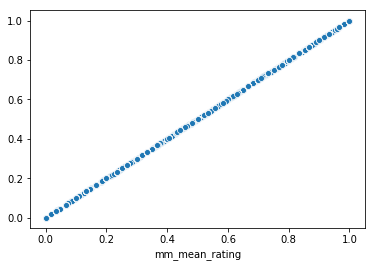

In [48]:
sns.scatterplot(df_contexts['mm_mean_rating'], 
                np.reshape(bert_input_nocut[6], -1))

## dscovar sentences in multi-sentence form for BERT crossprediction

In [12]:
df_dsc = pd.read_pickle('./dataset/cloze_df_scores_all3.pickle')

In [10]:
# DSCoVAR - BWS
sent_dsc_bert = np.load("dscovar_sentences_bert.pickle", allow_pickle=True)
score_dsc_bws = np.load("resp_bws.pickle", allow_pickle=True)

In [11]:
sent_dsc_bert

[array(['discord', 'rakish', 'defile', ..., 'deviate', 'frigid', 'adhere'],
       dtype='<U12'),
 array([' A discord  emerged between the two who were once friends . ',
        ' A bohemian is a person who is free-spirited and rakish  . ',
        ' A bunch of kids had broken in and defile  the paintings . ', ...,
        ' You will not get lost if you stay straight and do not deviate  . ',
        " You'll find what you're looking for when it becomes more frigid  . ",
        " Your plan's nice, but I doubt I could adhere  to it for long . "],
       dtype='<U109')]

In [25]:
contexts_dsc = sent_tokenizer_targ(nlp, pd.Series(sent_dsc_bert[1]), sent_dsc_bert[0])

In [31]:
contexts_dsc

array([{'sents': [' A discord  emerged between the two who were once friends .'], 'sent_tok': [[' ', 'A', 'discord', ' ', 'emerged', 'between', 'the', 'two', 'who', 'were', 'once', 'friends', '.']], 'target_insent': 'discord', 'target_stated': 'discord'},
       {'sents': [' A bohemian is a person who is free-spirited and rakish  .'], 'sent_tok': [[' ', 'A', 'bohemian', 'is', 'a', 'person', 'who', 'is', 'free', '-', 'spirited', 'and', 'rakish', ' ', '.']], 'target_insent': 'rakish', 'target_stated': 'rakish'},
       {'sents': [' A bunch of kids had broken in and defile  the paintings .'], 'sent_tok': [[' ', 'A', 'bunch', 'of', 'kids', 'had', 'broken', 'in', 'and', 'defile', ' ', 'the', 'paintings', '.']], 'target_insent': 'defile', 'target_stated': 'defile'},
       ...,
       {'sents': [' You will not get lost if you stay straight and do not deviate  .'], 'sent_tok': [[' ', 'You', 'will', 'not', 'get', 'lost', 'if', 'you', 'stay', 'straight', 'and', 'do', 'not', 'deviate', ' ', '.']

In [41]:
bert_example_dsc = convert_text_to_examples_kapelner([x['target_insent'] for x in contexts_dsc], 
                                                       [x['sent_tok'] for x in contexts_dsc],
                                                       score_dsc_bws, 
                                                       score_dsc_bws)

In [42]:
bert_input_dsc = convert_examples_to_features_kapelner(tokenizer, bert_example_dsc, False, MAX_SEQ_LEN_BERT)

In [44]:
len(bert_input_dsc[5])

1783

In [45]:
bert_input_dsc

(array([[ 101,  138,  103, ...,    0,    0,    0],
        [ 101,  138,  171, ...,    0,    0,    0],
        [ 101,  138, 9670, ...,    0,    0,    0],
        ...,
        [ 101, 1192, 1209, ...,    0,    0,    0],
        [ 101, 1192,  112, ...,    0,    0,    0],
        [ 101, 2353, 2197, ...,    0,    0,    0]]),
 array([[1, 1, 0, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]]),
 array([[0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1],
        ...,
        [0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 2, 2, 2]]),
 array([[0, 0, 1, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]),
 array(['discord', 'rakish', 'defile', .

In [47]:
np.savez("dscovar_sentences_notarg_bert_nocut_mult.npy", 
         input_ids = bert_input_dsc[0], 
         input_masks = bert_input_dsc[1], 
         segment_ids = bert_input_dsc[2], 
         targ_locs = bert_input_dsc[3], 
         targets = bert_input_dsc[4], 
#          lex_features = bert_input_nocut[5], 
         scores = bert_input_dsc[6])